In [ ]:

# Install required packages
!pip install deepchem rdkit-pypi shap xgboost

In [ ]:

#Import libraries
import numpy as np
import pandas as pd
import deepchem as dc
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
import shap
import matplotlib.pyplot as plt

In [ ]:

#Load Tox21 dataset from DeepChem
tox21_tasks, tox21_datasets, _ = dc.molnet.load_tox21()
train_dataset, valid_dataset, test_dataset = tox21_datasets

In [ ]:

#Convert DeepChem dataset to pandas DataFrame
def extract_features_labels(dataset):
    features = dataset.X
    labels = dataset.y
    smiles = dataset.ids  # IDs are SMILES strings in DeepChem
    return pd.DataFrame({'smiles': smiles, 'features': list(features), 'label': list(labels[:, 0])})

In [ ]:

train_df = extract_features_labels(train_dataset)
test_df = extract_features_labels(test_dataset)

In [ ]:

# Generate molecular fingerprints using RDKit
def smiles_to_fingerprint(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(n_bits)  # Handle invalid SMILES
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    return np.array(fp)

In [ ]:

train_df['fingerprint'] = train_df['smiles'].apply(smiles_to_fingerprint)
test_df['fingerprint'] = test_df['smiles'].apply(smiles_to_fingerprint)

Streaming output truncated to the last 5000 lines.
[20:16:48] DEPRECATION WARNING: please use MorganGenerator
[20:16:48] DEPRECATION WARNING: please use MorganGenerator
[20:16:48] DEPRECATION WARNING: please use MorganGenerator
[20:16:48] DEPRECATION WARNING: please use MorganGenerator
[20:16:48] DEPRECATION WARNING: please use MorganGenerator
[20:16:48] DEPRECATION WARNING: please use MorganGenerator
[20:16:48] DEPRECATION WARNING: please use MorganGenerator
[20:16:48] DEPRECATION WARNING: please use MorganGenerator
[20:16:48] DEPRECATION WARNING: please use MorganGenerator
[20:16:48] DEPRECATION WARNING: please use MorganGenerator
[20:16:48] DEPRECATION WARNING: please use MorganGenerator
[20:16:48] DEPRECATION WARNING: please use MorganGenerator
[20:16:48] DEPRECATION WARNING: please use MorganGenerator
[20:16:48] DEPRECATION WARNING: please use MorganGenerator
[20:16:48] DEPRECATION WARNING: please use MorganGenerator
[20:16:48] DEPRECATION WARNING: please use MorganGenerator
[20:1

In [ ]:

# Convert fingerprint lists to numpy arrays
X_train = np.stack(train_df['fingerprint'].values)
y_train = train_df['label'].values
X_test = np.stack(test_df['fingerprint'].values)
y_test = test_df['label'].values

In [ ]:

# Handle class imbalance
print(f"Class distribution:\nTrain: {pd.Series(y_train).value_counts(normalize=True)}\nTest: {pd.Series(y_test).value_counts(normalize=True)}")

Class distribution:
Train: 0.0    0.960051
1.0    0.039949
Name: proportion, dtype: float64
Test: 0.0    0.965517
1.0    0.034483
Name: proportion, dtype: float64


In [ ]:

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:

# Train XGBoost model
xgb_model = XGBClassifier(n_estimators=100, scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),
                          use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:30:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:

# Model evaluation function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

In [ ]:

from sklearn.metrics import roc_curve

def evaluate_model(model, X_test, y_test):
    """Evaluate classification model performance."""

    # Generate predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probability of class 1

    # Print classification report
    print(classification_report(y_test, y_pred))

    # Compute and print ROC AUC score
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"ROC AUC: {roc_auc:.3f}")

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})", color="blue")
    plt.plot([0, 1], [0, 1], linestyle="--", color="red")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

Random Forest Performance:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       756
         1.0       0.77      0.37      0.50        27

    accuracy                           0.97       783
   macro avg       0.87      0.68      0.74       783
weighted avg       0.97      0.97      0.97       783

ROC AUC: 0.705


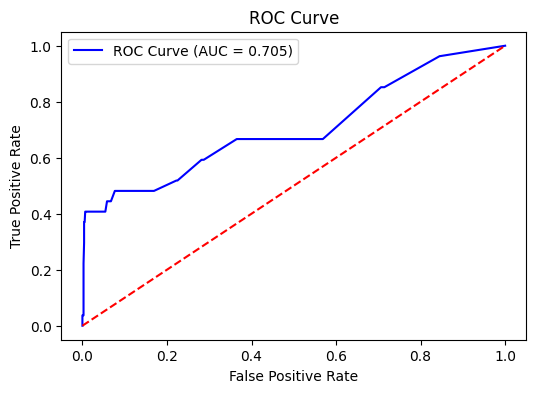

In [ ]:

print("Random Forest Performance:")
evaluate_model(rf_model, X_test, y_test)


XGBoost Performance:
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97       756
         1.0       0.31      0.33      0.32        27

    accuracy                           0.95       783
   macro avg       0.64      0.65      0.65       783
weighted avg       0.95      0.95      0.95       783

ROC AUC: 0.701


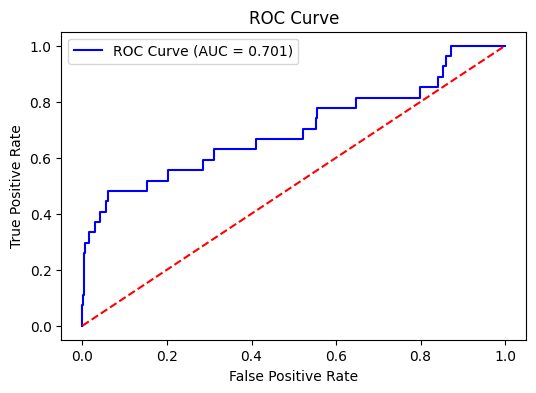

In [ ]:

print("\nXGBoost Performance:")
evaluate_model(xgb_model, X_test, y_test)

In [ ]:


# Feature importance analysis using SHAP
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

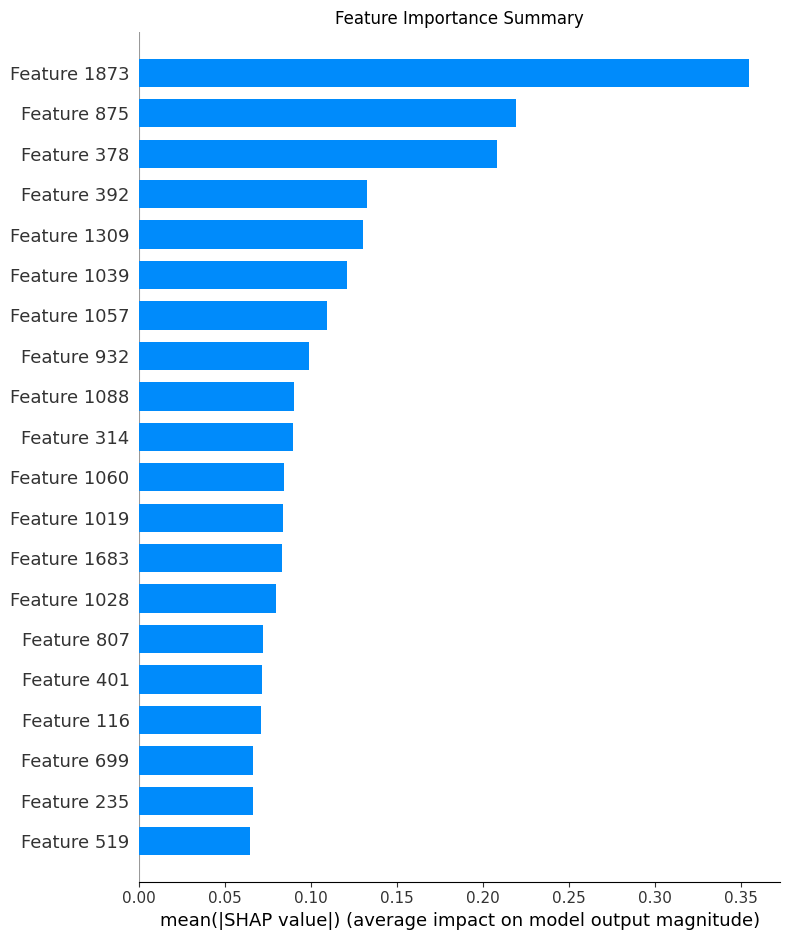

In [ ]:

plt.title('Feature Importance Summary')
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=20)

In [ ]:
#End